In [1]:
# =========================================================
# LIBRERÍAS
# =========================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prophet import Prophet
import matplotlib.pyplot as plt

Importing plotly failed. Interactive plots will not work.


### 📂 CARGAR DATOS
En esta etapa se cargan los datos desde un archivo de Excel, el cual contiene información detallada de las plantas de generación eléctrica en Colombia.
Las columnas principales del archivo son:


⚙️ Tipo/Fuente de energía


🔌 FUENTE DE ENERGIA


🏭 Despacho


⚡ Generador


📈 Capacidad efectiva neta [MW]


🧑‍💼 Operador


🗓️ Fecha de puesta en operación (FPO)


📍 Municipio


🗺️ Departamento


🌎 Subárea


Estos datos servirán como base para analizar la evolución de la capacidad instalada y las tendencias por tipo de fuente energética.


In [3]:
df_0 = pd.read_excel('PARATEC_Capacidadefectiva_27-10-2025.xlsx', sheet_name='CapacidadEfectiva_2', skiprows=7)

## 🧹 LIMPIEZA DE DATOS

Antes de realizar cualquier análisis, es fundamental asegurar que los datos estén limpios, consistentes y libres de errores.
En esta etapa se llevan a cabo las siguientes tareas:

🧾 Corrección de tipos de datos, garantizando que las fechas estén en formato datetime y las capacidades sean numéricas.

⚙️ Normalización de nombres en columnas.

Esta limpieza asegura que la base de datos refleje fielmente la información de las plantas de generación, permitiendo análisis precisos y resultados confiables.

In [5]:
# 1. Eliminar las filas sin datos

ultimas_5 = df_0.columns[-5:]  # Selección de las últimas 5 columnas
df = df_0.dropna(subset=ultimas_5, how='all')

# 2. Cambiar el nombre de la columna por un nombre mas explicito
df = df.rename(columns={'Tipo/Fuente de energía': 'NombrePlanta'})

# 3. Convertir los datos de string a número
df['Capacidad efectiva neta [MW]'] = (
    df['Capacidad efectiva neta [MW]']
    .astype(str)
    .str.replace('.', '', regex=False)   # Quita separador de miles
    .str.replace(',', '.', regex=False)  # Cambia separador decimal
    .astype(float)
)

# 4. Convertir texto a fecha con formato día/mes/año
df['Fecha de puesta en operación FPO'] = pd.to_datetime(df['Fecha de puesta en operación FPO'], format='%d/%m/%Y', errors='coerce')

### ⚙️ CALCULAR LA CAPACIDAD ACUMULADA
Cada registro representa una planta con su respectiva capacidad efectiva neta.
Para conocer la evolución del sistema eléctrico en el tiempo, se calcula la capacidad acumulada, es decir, la suma progresiva de las capacidades de todas las plantas conforme entran en operación.
Este valor nos permitirá visualizar el crecimiento histórico de la infraestructura de generación.

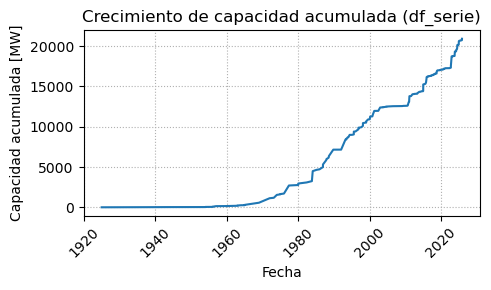

In [7]:
df_serie = df[['Fecha de puesta en operación FPO', 'Capacidad efectiva neta [MW]', 'FUENTE DE ENERGIA']].copy()

df_serie = df_serie.sort_values(by='Fecha de puesta en operación FPO', ascending=True).reset_index(drop=True)

# Crear la columna de capacidad acumulada
df_serie['Capacidad acumulada [MW]'] = df_serie['Capacidad efectiva neta [MW]'].cumsum()

# ==============================
# 1. FIGURA: df_serie
# ==============================
plt.figure(figsize=(5,3))
plt.plot(df_serie['Fecha de puesta en operación FPO'],
         df_serie['Capacidad acumulada [MW]'])
plt.xlabel('Fecha')
plt.ylabel('Capacidad acumulada [MW]')
plt.title('Crecimiento de capacidad acumulada (df_serie)')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

### 📊 Figura: capacidad acumulada diferenciada por tipo de generación
En esta figura se muestra la evolución de la capacidad acumulada a lo largo del tiempo, diferenciada por tipo o fuente de energía (solar, hidráulica, térmica, etc.).
Este gráfico facilita identificar cuáles tecnologías han contribuido en mayor medida al crecimiento del sistema eléctrico colombiano.

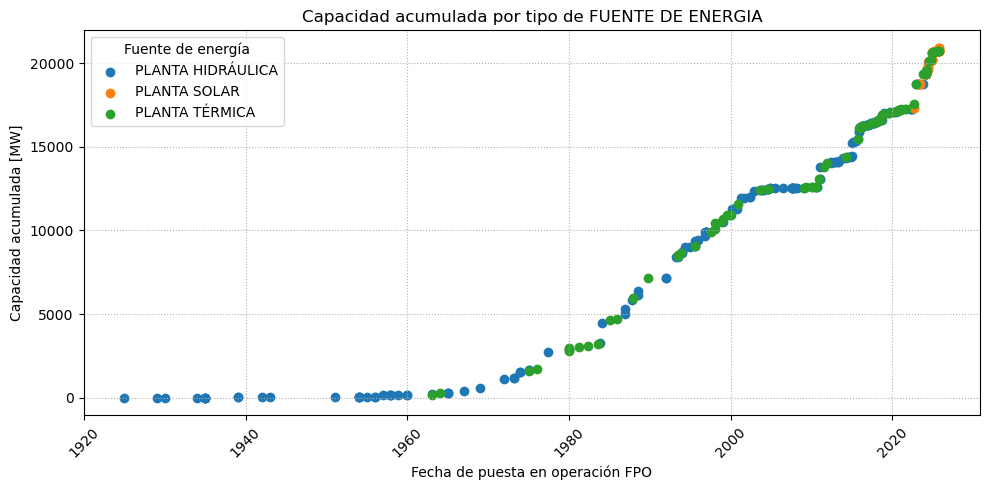

In [9]:
plt.figure(figsize=(10,5))

# Recorrer cada categoría de fuente energética y graficarla con una etiqueta
for fuente, df_sub in df_serie.groupby('FUENTE DE ENERGIA'):
    plt.scatter(df_sub['Fecha de puesta en operación FPO'],
                df_sub['Capacidad acumulada [MW]'],
                label=fuente)

plt.xlabel('Fecha de puesta en operación FPO')
plt.ylabel('Capacidad acumulada [MW]')
plt.title('Capacidad acumulada por tipo de FUENTE DE ENERGIA')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':')
plt.legend(title='Fuente de energía')
plt.tight_layout()
plt.show()

### 📈 Figura: capacidad discretizada y acumulada por tipo de generación
Aquí se presenta la comparación entre:


La capacidad discretizada, que muestra los incrementos puntuales cuando nuevas plantas entran en operación.


La capacidad acumulada, que refleja el crecimiento total alcanzado hasta cada fecha.


Esta visualización permite comprender la dinámica de incorporación de nuevas plantas y su impacto sobre el total acumulado.

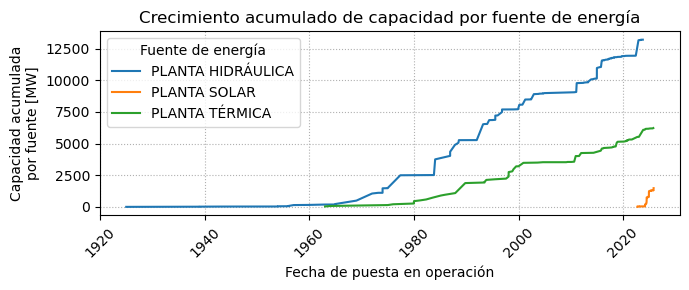

In [11]:
# Ordenar por fecha para garantizar correcta acumulación
df_acum_fuente = df_serie.sort_values(by='Fecha de puesta en operación FPO').copy()

# Acumulado por cada fuente de energía
df_acum_fuente['Capacidad acumulada por fuente [MW]'] = (
    df_acum_fuente
    .groupby('FUENTE DE ENERGIA')['Capacidad efectiva neta [MW]']
    .cumsum())

plt.figure(figsize=(7,3))

# Recorrer cada fuente energética y graficar su curva acumulada
for fuente, df_sub in df_acum_fuente.groupby('FUENTE DE ENERGIA'):
    plt.plot(df_sub['Fecha de puesta en operación FPO'],
             df_sub['Capacidad acumulada por fuente [MW]'],
             label=fuente)

plt.xlabel('Fecha de puesta en operación')
plt.ylabel('Capacidad acumulada\npor fuente [MW]')
plt.title('Crecimiento acumulado de capacidad por fuente de energía')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':')
plt.legend(title='Fuente de energía')
plt.tight_layout()
plt.show()

### 🧮 CREAR UN DATAFRAME DIARIO (FECHA - VALOR)

Para analizar el crecimiento de forma continua, es necesario construir una serie temporal diaria.
Las fechas de puesta en operación no siguen intervalos regulares, por lo que se genera un dataframe diario entre la fecha mínima y máxima de la serie.

La regla aplicada es:

Si en una fecha no entra una nueva planta en operación, el valor de capacidad acumulada se mantiene igual al del día anterior.

De esta manera, se obtiene una serie uniforme donde el valor se mantiene constante entre fechas de nuevos ingresos, reflejando el comportamiento real del crecimiento acumulado.

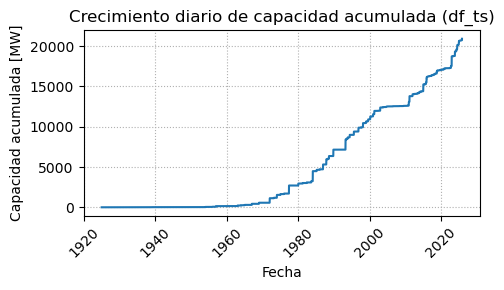

In [13]:
# 1. Tomar solo columnas necesarias
df_ts = df_serie[['Fecha de puesta en operación FPO', 'Capacidad acumulada [MW]', 'FUENTE DE ENERGIA']].copy()

# 2. Agrupar por fecha conservando el mayor valor si hay duplicados
df_ts = df_ts.groupby('Fecha de puesta en operación FPO').max()

# 3. Crear índice de fecha en orden creciente
df_ts = df_ts.sort_index()

# 4. Crear un rango diario desde la fecha mínima hasta la máxima
rango_fechas = pd.date_range(start=df_ts.index.min(), end=df_ts.index.max(), freq='D')

# 5. Reindexar al rango diario y rellenar faltantes con el último valor conocido
df_ts = df_ts.reindex(rango_fechas).ffill()

# 6. Renombrar índice a Fecha
df_ts.index.name = 'Fecha'

# ==============================
# 2. FIGURA: df_ts (serie diaria)
# ==============================
plt.figure(figsize=(5,3))
plt.plot(df_ts.index,
         df_ts['Capacidad acumulada [MW]'])
plt.xlabel('Fecha')
plt.ylabel('Capacidad acumulada [MW]')
plt.title('Crecimiento diario de capacidad acumulada (df_ts)')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

### 🔍 Comparación entre la serie con intervalos variables y la serie diaria

En esta sección se comparan dos representaciones de la capacidad acumulada:

Serie con intervalos variables: usa las fechas reales de entrada en operación.

Serie diaria: interpola valores constantes para cada día del rango analizado.

Esta comparación permite evaluar la influencia de la interpolación temporal y analizar la suavidad, continuidad y precisión de ambas representaciones.

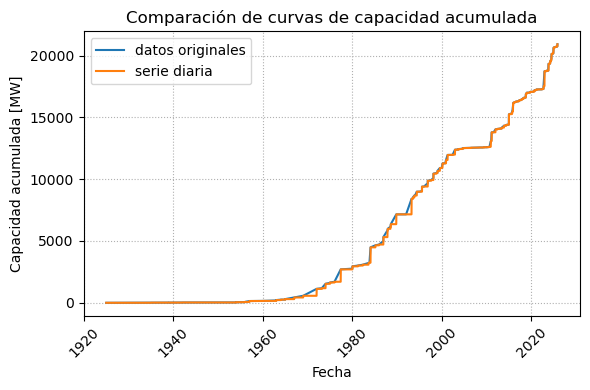

In [15]:
# ==============================
# 3. FIGURA: Comparación juntas
# ==============================
plt.figure(figsize=(6,4))
plt.plot(df_serie['Fecha de puesta en operación FPO'],
         df_serie['Capacidad acumulada [MW]'],
         label='datos originales')
plt.plot(df_ts.index,
         df_ts['Capacidad acumulada [MW]'],
         label='serie diaria')
plt.xlabel('Fecha')
plt.ylabel('Capacidad acumulada [MW]')
plt.title('Comparación de curvas de capacidad acumulada')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

## ☀️ PROYECCIÓN DE CAPACIDAD ENERGÉTICA SOLAR

En esta fase se realiza una proyección del crecimiento de la capacidad instalada de energía solar.
En Colombia, la tendencia apunta a limitar la expansión de la energía hidroeléctrica debido a sus altos costos ambientales, mientras que se promueve activamente la energía solar como alternativa sostenible y de rápido crecimiento.

La proyección se desarrolla utilizando cuatro modelos de predicción:

📉 Linear Regression

🌳 Random Forest

⚙️ XGBoost

🔮 Prophet

Para mejorar el rendimiento y la estabilidad de los modelos, se aplica una media móvil de 30 días sobre la serie de capacidad solar acumulada.
Este suavizado reduce las fluctuaciones de corto plazo y permite capturar con mayor claridad la tendencia general del crecimiento solar.het

16:44:09 - cmdstanpy - INFO - Chain [1] start processing
16:44:10 - cmdstanpy - INFO - Chain [1] done processing


             Modelo        R2         MAE        RMSE
0  LinearRegression  0.937626  244.393885  295.994636
1      RandomForest  0.999492   16.935735   26.724142
2           XGBoost  0.999903    3.439687   11.654681
3           Prophet  0.998897   21.666075   39.363436
✅ Resultados guardados en: proyeccion_capacidad_solar.xlsx


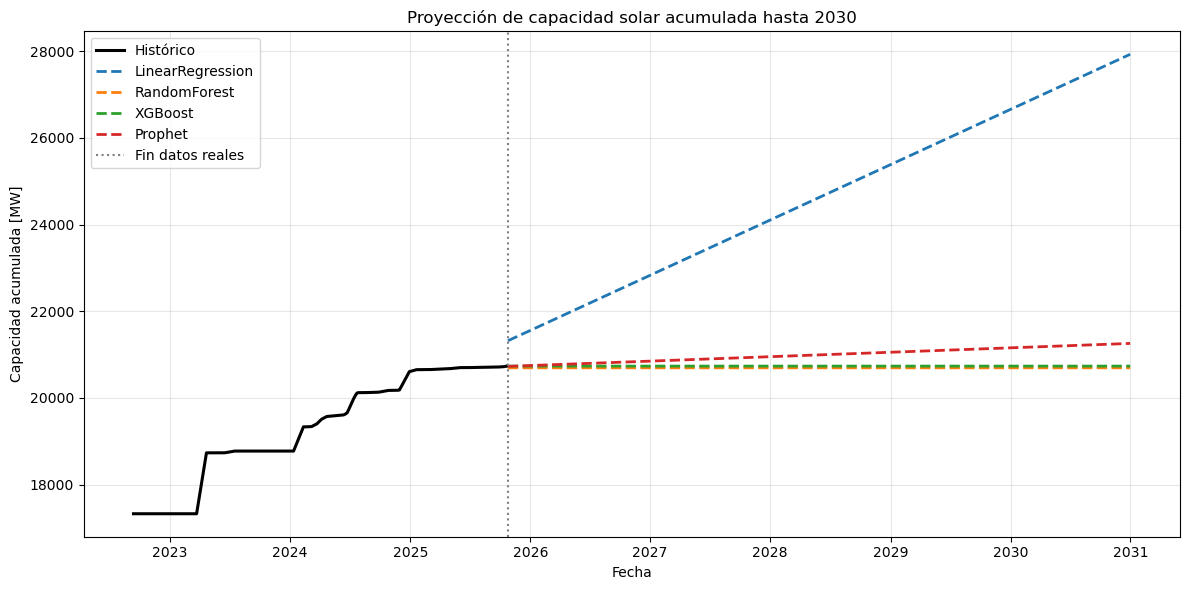

In [17]:
# ============================================================
# 1. VARIABLES
# ============================================================
# --- 1. Filtrar solo plantas solares ---
df_ts_solar = df_ts[df_ts['FUENTE DE ENERGIA'] == 'PLANTA SOLAR'].copy()

# --- 2. Ordenar el índice por fecha ---
df_ts_solar = df_ts_solar.sort_index()

# --- 3. Crear rango diario desde la fecha mínima a la máxima ---
rango_fechas = pd.date_range(start=df_ts_solar.index.min(), end=df_ts_solar.index.max(), freq='D')

# --- 4. Reindexar para incluir todas las fechas del rango ---
df_ts_solar = df_ts_solar.reindex(rango_fechas)

# --- 5. Rellenar valores faltantes hacia adelante y atrás ---
df_ts_solar = df_ts_solar.ffill().bfill()

# --- 6. Renombrar el índice ---
df_ts_solar.index.name = 'Fecha'

# Crear la variable de tiempo continua (días desde la fecha inicial)
df_ts_solar['t'] = (df_ts_solar.index - df_ts_solar.index.min()).days

# df_ts_solar['Capacidad_suavizada'] = df_ts_solar['Capacidad acumulada [MW]'].ewm(span=10, adjust=False).mean()
df_ts_solar['Capacidad_suavizada'] = df_ts_solar['Capacidad acumulada [MW]'].rolling(window=30, min_periods=1).mean()

# Variable dependiente (target)
y = df_ts_solar['Capacidad_suavizada']

# Variables independientes
X = pd.DataFrame({'t': df_ts_solar['t']})

# ============================================================
# 2. MODELOS
# ============================================================

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(
        n_estimators=800,
        max_depth=4,
        min_samples_leaf=5,
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42
    )
}

# Entrenar modelos clásicos
for name, model in models.items():
    model.fit(X, y)

# ============================================================
# 3. PROPHET
# ============================================================

df_prophet = df_ts_solar.reset_index()[['Fecha', 'Capacidad_suavizada']].rename(
    columns={'Fecha': 'ds', 'Capacidad_suavizada': 'y'}
)

prophet_model = Prophet(yearly_seasonality=False, daily_seasonality=False)
prophet_model.fit(df_prophet)

# ============================================================
# 4. PROYECCIONES FUTURAS
# ============================================================

fecha_max = df_ts_solar.index.max()
fechas_futuras = pd.date_range(fecha_max + pd.Timedelta(days=1), '2030-12-31', freq='D')
t_fut = (fechas_futuras - df_ts_solar.index.min()).days
X_fut = pd.DataFrame({'t': t_fut})

# Predicciones
predicciones = {name: model.predict(X_fut) for name, model in models.items()}

# Prophet
futuro_prophet = prophet_model.make_future_dataframe(periods=len(fechas_futuras), freq='D')
forecast_prophet = prophet_model.predict(futuro_prophet)
pred_prophet = forecast_prophet.set_index('ds').loc[fechas_futuras, 'yhat']

predicciones['Prophet'] = pred_prophet.values

# ============================================================
# 5. EVALUACIÓN DE MODELOS (EN DATOS HISTÓRICOS)
# ============================================================

metricas = []
for name, model in models.items():
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred) ** 0.5
    metricas.append([name, r2, mae, rmse])

# Prophet (evaluación sobre datos reales)
y_pred_prophet = prophet_model.predict(df_prophet)[['yhat']].values.flatten()
r2 = r2_score(y, y_pred_prophet)
mae = mean_absolute_error(y, y_pred_prophet)
rmse = mean_squared_error(y, y_pred_prophet) ** 0.5
metricas.append(['Prophet', r2, mae, rmse])

df_metricas = pd.DataFrame(metricas, columns=['Modelo', 'R2', 'MAE', 'RMSE'])
print(df_metricas)

# ============================================================
# 6. UNIFICAR RESULTADOS PARA GUARDAR
# ============================================================

# Datos reales
df_real = df_ts_solar[['Capacidad_suavizada']].rename(columns={'Capacidad_suavizada': 'Histórico'})

# Datos futuros
df_fut = pd.DataFrame(index=fechas_futuras)
for name, y_pred in predicciones.items():
    df_fut[name] = y_pred

# Concatenar
df_resultado = pd.concat([df_real, df_fut])

# Guardar en Excel
ruta_salida = 'proyeccion_capacidad_solar.xlsx'
with pd.ExcelWriter(ruta_salida, engine='openpyxl') as writer:
    df_resultado.to_excel(writer, sheet_name='Proyeccion')
    df_metricas.to_excel(writer, sheet_name='Metricas', index=False)

print(f"✅ Resultados guardados en: {ruta_salida}")

# ============================================================
# 7. GRAFICAR
# ============================================================

plt.figure(figsize=(12, 6))
plt.plot(df_real.index, df_real['Histórico'], color='black', linewidth=2.2, label='Histórico')

for name in predicciones.keys():
    plt.plot(fechas_futuras, df_fut[name], '--', linewidth=2, label=name)

plt.axvline(df_real.index.max(), color='gray', linestyle=':', label='Fin datos reales')
plt.xlabel('Fecha')
plt.ylabel('Capacidad acumulada [MW]')
plt.title('Proyección de capacidad solar acumulada hasta 2030')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()